In [1]:
import pandas as pd

# Load metadata
df = pd.read_csv("ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptbxl_database.csv")

# Use only 100 Hz signals
df_100hz = df.copy()  # All rows have both HR and LR paths

In [2]:
import wfdb
import numpy as np

def load_lead1_from_lr(record_path):
    record = wfdb.rdrecord(record_path)
    lead_names = record.sig_name
    lead1_idx = lead_names.index('I')  # 'I' is Lead I
    return record.p_signal[:, lead1_idx]

signals = []
for path in df_100hz['filename_lr']:
    full_path = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/" + path  # or your path to records100
    signal = load_lead1_from_lr(full_path)
    signals.append(signal)


NameError: name 'signals' is not defined

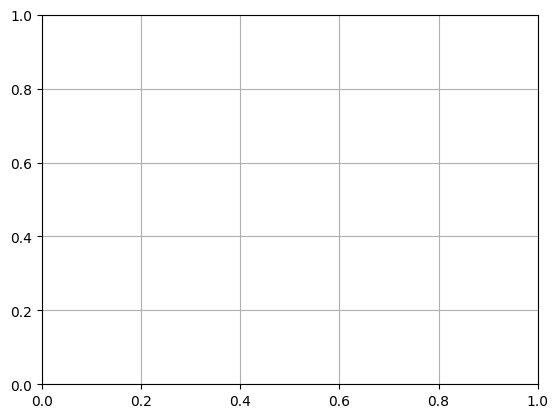

In [35]:
import matplotlib.pyplot as plt 

n = np.linspace(0,10,1000)

plt.grid()
plt.plot(n , signals[1005])

c:\Users\darkoob\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


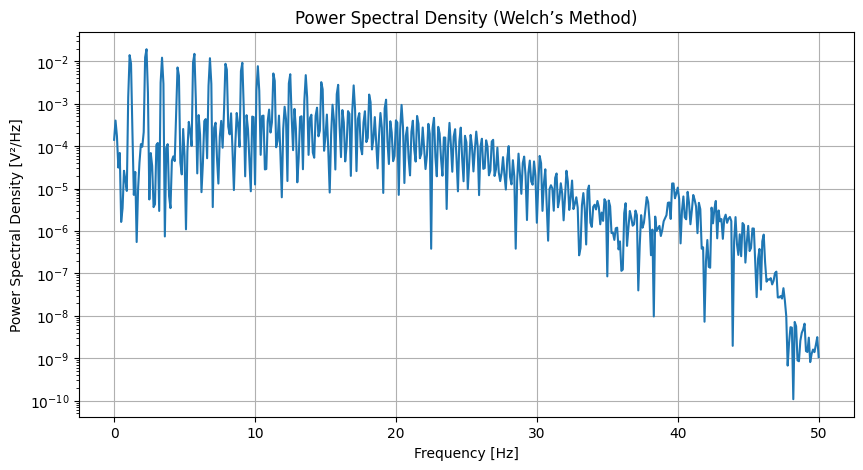

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

fs = 100  # Sampling frequency (Hz)
t = np.arange(0, 1, 1/fs)  # Time vector
x = signals[1000]

# Compute PSD using Welch's method
f, Pxx = signal.welch(x, fs, nperseg=1024)

# Plot PSD
plt.figure(figsize=(10, 5))
plt.semilogy(f, Pxx)  # Plot in log scale (optional: plt.plot(f, Pxx) for linear scale)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V²/Hz]')
plt.title('Power Spectral Density (Welch’s Method)')
plt.grid()
plt.show()

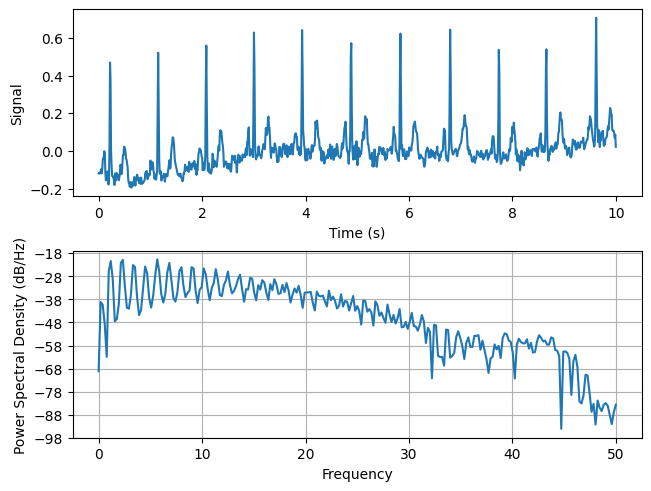

In [5]:
fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, signals[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
ax1.psd(signals[1000], NFFT=512, Fs=fs)

plt.show()

In [6]:
from scipy.signal import firwin, filtfilt

def bandpass_filter(signal, fs=100, lowcut=1, highcut=40, numtaps=201):
    nyq = fs / 2
    taps = firwin(numtaps, [lowcut / nyq, highcut / nyq], pass_zero=False)
    filtered = filtfilt(taps, [1.0], signal)
    return filtered
def remove_mean(signal):
    return signal - np.mean(signal)
def min_max_scale(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return np.zeros_like(signal)  # avoid divide by zero
    return (signal - min_val) / (max_val - min_val)

In [7]:
def preprocess_ecg(signal, fs=100):
    filtered = bandpass_filter(signal, fs=fs)
    zero_mean = remove_mean(filtered)
    scaled = min_max_scale(zero_mean)
    return scaled

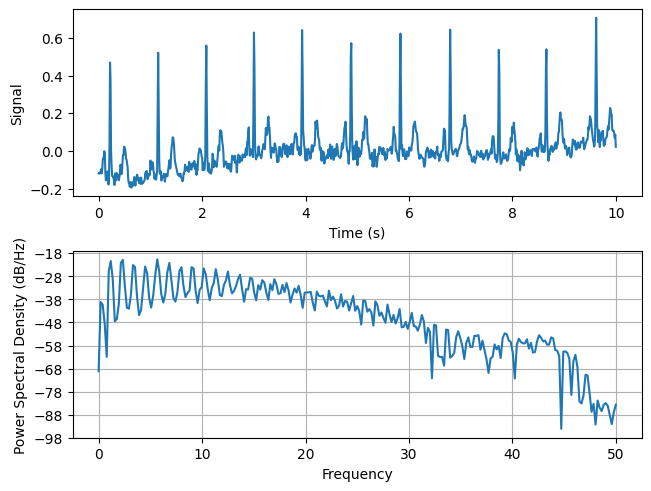

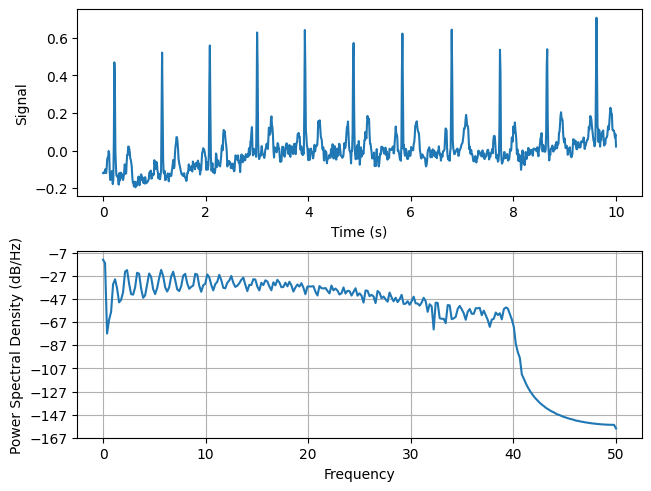

In [8]:
fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, signals[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
ax1.psd(signals[1000], NFFT=512, Fs=fs)

plt.show()

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, signals[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
ax1.psd(preprocess_ecg(signals[1000]), NFFT=512, Fs=fs)

plt.show()

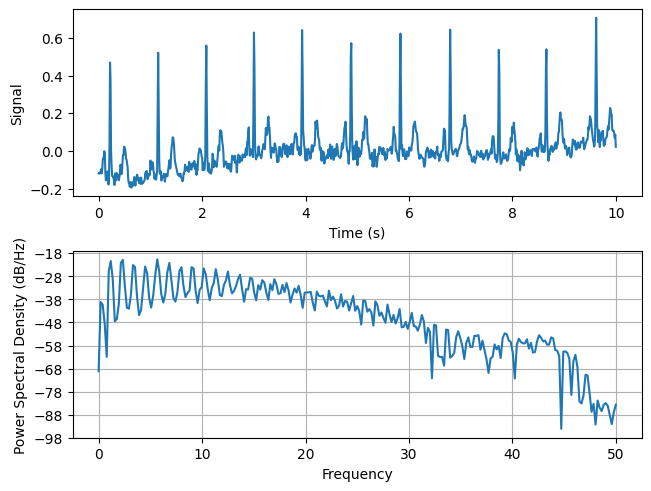

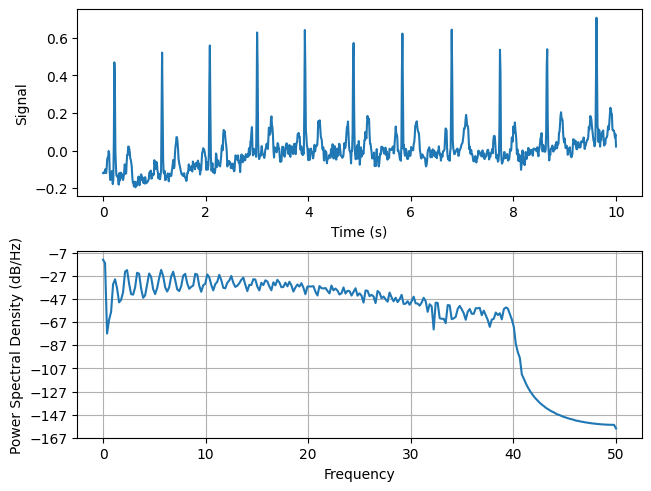

In [9]:
fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, signals[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
ax1.psd(signals[1000], NFFT=512, Fs=fs)

plt.show()

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, signals[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
ax1.psd(preprocess_ecg(signals[1000]), NFFT=512, Fs=fs)

plt.show()

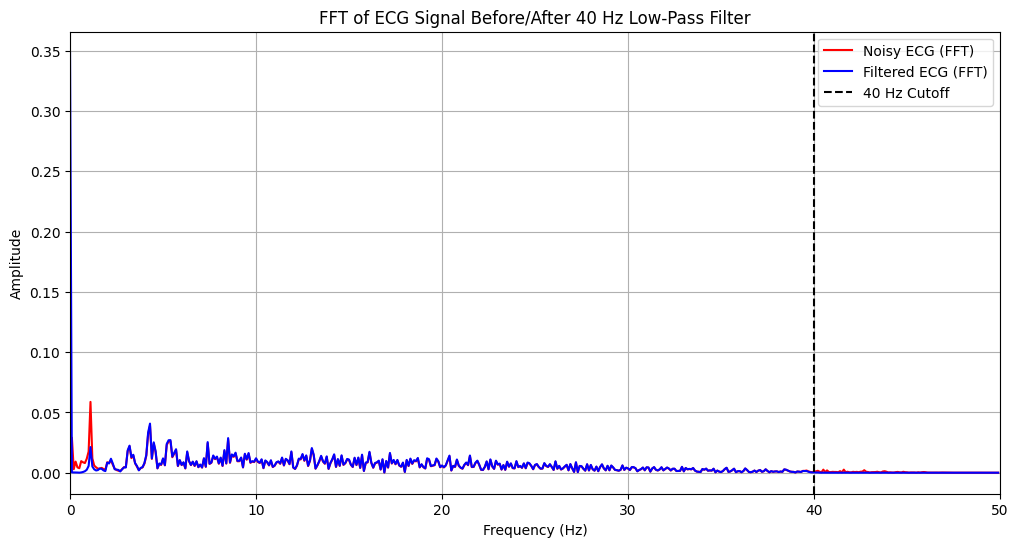

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Compute FFTs
def compute_fft(y, fs):
    n = len(y)
    yf = fft(y)
    xf = fftfreq(n, 1 / fs)[:n // 2]  # Positive frequencies only
    return xf, 2.0 / n * np.abs(yf[0:n // 2])

xf, yf_noisy = compute_fft(signals[10001], fs)
_, yf_filtered = compute_fft(preprocess_ecg(signals[10001]), fs)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(xf, yf_noisy, 'r-', label='Noisy ECG (FFT)')
plt.plot(xf, yf_filtered, 'b-', label='Filtered ECG (FFT)')
plt.axvline(40, color='k', linestyle='--', label='40 Hz Cutoff')
plt.xlim(0, 50)  # Focus on 0-100 Hz
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of ECG Signal Before/After 40 Hz Low-Pass Filter')
plt.legend()
plt.grid()
plt.show()

In [13]:
preprecessed_signals = np.array([preprocess_ecg(sig) for sig in signals])

In [15]:
import numpy as np
import colorednoise as cn

def generate_pink_noise(length):
    beta = 1  # 1/f^1 for pink noise
    return cn.powerlaw_psd_gaussian(beta, length)

def add_pink_noise_with_snr(signal, mu_snr_db=-1.62, sigma_snr_db=1.71):
    length = len(signal)
    signal_power = np.mean(signal ** 2)
    
    # Sample a target SNR in dB
    target_snr_db = np.random.normal(mu_snr_db, sigma_snr_db)
    target_snr_linear = 10 ** (target_snr_db / 10)

    # Compute required noise power
    noise_power = signal_power / target_snr_linear

    # Generate pink noise
    pink_noise = generate_pink_noise(length)

    # Scale pink noise to desired power
    current_noise_power = np.mean(pink_noise ** 2)
    scaling_factor = np.sqrt(noise_power / current_noise_power)
    scaled_noise = pink_noise * scaling_factor
    scaled_noise = bandpass_filter(scaled_noise)
    # Return noisy signal and actual SNR
    noisy_signal = signal + scaled_noise
    actual_snr_db = 10 * np.log10(np.mean(signal ** 2) / np.mean(scaled_noise ** 2))
    
    return noisy_signal


In [16]:
signals_with_pinknoise = np.array([add_pink_noise_with_snr(preprecessed_signals[i]) for i in range(len(preprecessed_signals))])

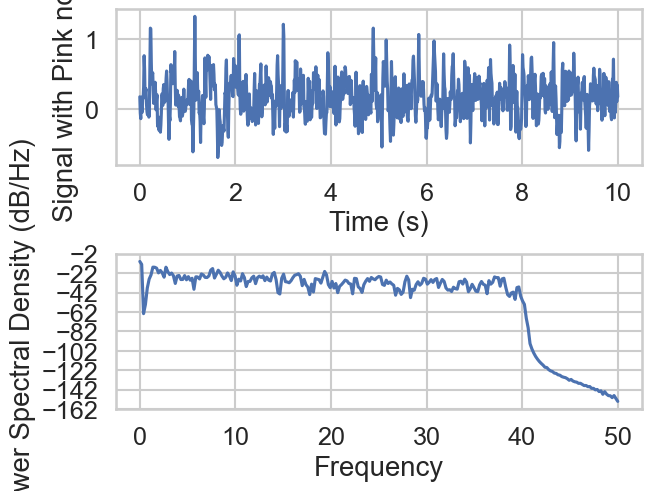

In [74]:
plt.show()
fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, signals_with_pinknoise[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal with Pink noise')
ax1.psd(signals_with_pinknoise[0], NFFT=512, Fs=fs)

plt.show()

In [18]:
np.savez('outputs.npz', noisy=signals_with_pinknoise, clean=preprecessed_signals)

In [2]:
import numpy as np
# Load the .npz file
data = np.load('outputs.npz')

# Access the saved arrays by their keys
noisy_signals = data['noisy']  # Access 'noisy' array
clean_signals = data['clean']  # Access 'clean' array

# Print shapes to verify
print("Noisy signals shape:", noisy_signals.shape)
print("Clean signals shape:", clean_signals.shape)

# Close the file when done (optional but good practice)
data.close()

Noisy signals shape: (21799, 1000)
Clean signals shape: (21799, 1000)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DCAE(nn.Module):
    def __init__(self):
        super(DCAE, self).__init__()
        
        # Encoder (4 Conv Layers)
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=75, padding=37),  # 0.75s kernel (75 samples @ 100Hz)
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Conv1d(16, 32, kernel_size=45, padding=22),  # 0.45s kernel
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 32, kernel_size=45, padding=22),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 32, kernel_size=45, padding=22),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        
        # Decoder (4 Transpose Conv Layers)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 32, kernel_size=45, padding=22),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.ConvTranspose1d(32, 32, kernel_size=45, padding=22),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.ConvTranspose1d(32, 16, kernel_size=45, padding=22),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            
            nn.ConvTranspose1d(16, 1, kernel_size=75, padding=37),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = DCAE().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(noisy_signals, clean_signals, test_size=0.05, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42)

# Convert to tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32).unsqueeze(1),
                            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [76]:
best_val_loss = float('inf')
patience = 10  # Stop after 10 epochs without improvement
patience_counter = 0
model_path = 'best_dcae_model.pth'

num_epochs = 75
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for noisy_batch, clean_batch in train_loader:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        output = model(noisy_batch)
        loss = criterion(output, clean_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy_batch, clean_batch in val_loader:
            noisy_batch = noisy_batch.to(device)
            clean_batch = clean_batch.to(device)
            output = model(noisy_batch)
            loss = criterion(output, clean_batch)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_path)  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
            break

Epoch 1: Train Loss = 0.034600, Val Loss = 0.028335
Epoch 2: Train Loss = 0.026831, Val Loss = 0.027659
Epoch 3: Train Loss = 0.021856, Val Loss = 0.019551
Epoch 4: Train Loss = 0.017871, Val Loss = 0.017666
Epoch 5: Train Loss = 0.017298, Val Loss = 0.016154
Epoch 6: Train Loss = 0.016385, Val Loss = 0.012307
Epoch 7: Train Loss = 0.010908, Val Loss = 0.009613
Epoch 8: Train Loss = 0.009401, Val Loss = 0.008872
Epoch 9: Train Loss = 0.008648, Val Loss = 0.009067


KeyboardInterrupt: 

In [90]:
best_val_loss = float('inf')
patience = 10  # Stop after 10 epochs without improvement
patience_counter = 0
model_path = 'best_dcae_model.pth'

num_epochs = 75
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for noisy_batch, clean_batch in train_loader:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        output = model(noisy_batch)
        loss = criterion(output, clean_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy_batch, clean_batch in val_loader:
            noisy_batch = noisy_batch.to(device)
            clean_batch = clean_batch.to(device)
            output = model(noisy_batch)
            loss = criterion(output, clean_batch)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_path)  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
            break

KeyboardInterrupt: 

In [23]:
print(model)

DCAE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(75,), stride=(1,), padding=(37,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(16, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(32, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv1d(32, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(32, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (1): BatchNorm1d(32, eps=1e-05,

In [6]:
def predict_denoised_signal(model, noisy_input, device='cpu', return_numpy=True):
    #model.eval()
    #model.to(device)

    # Convert to tensor if needed
    if isinstance(noisy_input, np.ndarray):
        noisy_tensor = torch.tensor(noisy_input, dtype=torch.float32)
    else:
        noisy_tensor = noisy_input.float()

    # Ensure shape: [B, 1, L]
    if noisy_tensor.ndim == 1:
        noisy_tensor = noisy_tensor.unsqueeze(0).unsqueeze(0)  # [1, 1, L]
    elif noisy_tensor.ndim == 2:
        noisy_tensor = noisy_tensor.unsqueeze(1)  # [B, 1, L]

    # Move to device
    noisy_tensor = noisy_tensor.to(device)

    with torch.no_grad():
        denoised = model(noisy_tensor)

    # Move back to CPU and remove extra dims
    denoised = denoised.squeeze(1)  # [B, L]

    if return_numpy:
        return denoised.cpu().numpy()
    return denoised

In [67]:
# Recreate the same model architecture
model = DCAE().to(device)

# Load weights
model.load_state_dict(torch.load("best_dcae_model.pth", map_location=device))
model.eval()

DCAE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(75,), stride=(1,), padding=(37,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(16, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(32, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv1d(32, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(32, 32, kernel_size=(45,), stride=(1,), padding=(22,))
    (1): BatchNorm1d(32, eps=1e-05,

In [8]:
import numpy as np

def calculate_snr(clean_signal, noisy_signal):
    # Ensure inputs are numpy arrays
    clean = np.asarray(clean_signal)
    noisy = np.asarray(noisy_signal)
    
    # Calculate signal power (sum of squares)
    signal_power = np.sum(clean**2)
    
    # Calculate noise power (sum of squared differences)
    noise_power = np.sum((clean - noisy)**2)
    
    # Avoid division by zero
    if noise_power == 0:
        return float('inf')
    
    # Calculate SNR in dB (10*log10(signal_power/noise_power))
    snr_db = 10 * np.log10(signal_power / noise_power)
    
    return snr_db

In [68]:
from sklearn.metrics import r2_score

y_pred = predict_denoised_signal(model , X_test[0])
calculate_snr(y_test[0], y_pred[0])

np.float64(12.905830136433066)

In [53]:
y_pred

array([[0.2289493 , 0.22873025, 0.22011384, 0.22191085, 0.21675746,
        0.225457  , 0.21534029, 0.20211695, 0.20839944, 0.20502521,
        0.21538213, 0.21545637, 0.20615786, 0.21031882, 0.21468218,
        0.21012747, 0.20799175, 0.19344415, 0.19593902, 0.20473285,
        0.19513966, 0.18579084, 0.18936127, 0.20562932, 0.20184094,
        0.20263536, 0.2125196 , 0.18576242, 0.20483734, 0.19180878,
        0.2101086 , 0.20708783, 0.17933466, 0.1872616 , 0.17896812,
        0.15293191, 0.1493349 , 0.16068265, 0.14814194, 0.18192394,
        0.20647775, 0.27711657, 0.38431072, 0.69234717, 0.87294006,
        0.8171676 , 0.5395747 , 0.3450489 , 0.26684198, 0.19114935,
        0.15527968, 0.15810163, 0.12472882, 0.11509656, 0.10918161,
        0.11246663, 0.11083203, 0.13434196, 0.11100186, 0.1034787 ,
        0.12082719, 0.11381721, 0.13629124, 0.14606455, 0.13860457,
        0.14454775, 0.16373746, 0.17275667, 0.18406902, 0.19947028,
        0.18792824, 0.23049235, 0.23099485, 0.24

In [54]:
calculate_snr(y_test[0], X_test[0])

np.float64(3.734499799123603)

In [69]:
SNR_in = []
SNR_out = []

for i in range(len(X_test)//5):
    y_pred = predict_denoised_signal(model , X_test[i])
    SNR_out.append(calculate_snr(y_test[i], y_pred[0]))
    SNR_in.append(calculate_snr(y_test[i], X_test[i]))


C:\Users\darkoob\AppData\Local\Temp\ipykernel_9160\172870490.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Condition", y="SNR (dB)", data=df,


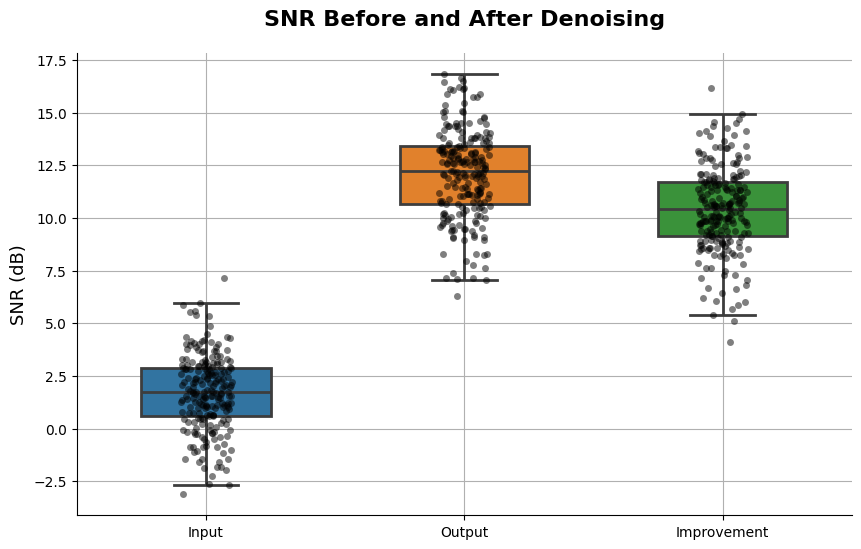

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_snr_boxplot(snr_in, snr_out, save_path=None):

    #sns.set(style="whitegrid", context="talk", font_scale=1.1)

    # Prepare data
    snr_improvement = np.array(snr_out) - np.array(snr_in)
    df = pd.DataFrame({
        "SNR (dB)": np.concatenate([snr_in, snr_out, snr_improvement]),
        "Condition": (["Input"] * len(snr_in) +
                      ["Output"] * len(snr_out) +
                      ["Improvement"] * len(snr_improvement))
    })

    # Create figure
    plt.figure(figsize=(10, 6))
    palette = {"Input": "#1f77b4", "Output": "#ff7f0e", "Improvement": "#2ca02c"}

    # Boxplot + swarmplot
    ax = sns.boxplot(x="Condition", y="SNR (dB)", data=df, 
                     palette=palette, width=0.5, linewidth=2, showfliers=False)
    sns.stripplot(x="Condition", y="SNR (dB)", data=df, 
                  color="black", size=5, alpha=0.5, jitter=True)
   
    # Titles and labels
    plt.title("SNR Before and After Denoising", pad=20, fontsize=16, fontweight="bold")
    plt.ylabel("SNR (dB)", fontsize=13)
    plt.xlabel("")
    sns.despine()

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.grid()
    plt.show()



plot_snr_boxplot(SNR_in, SNR_out)

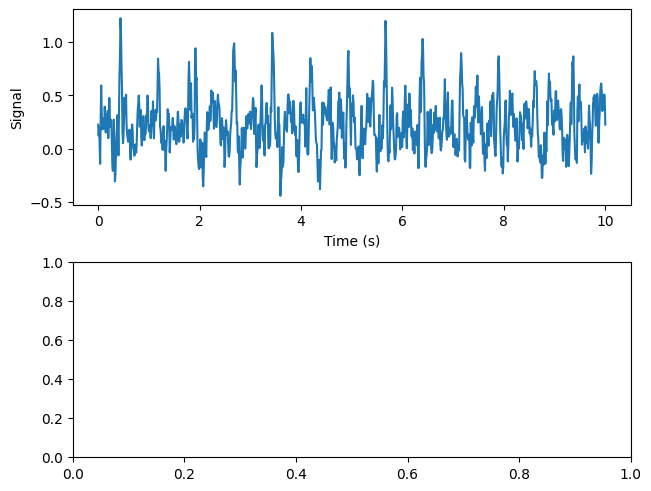

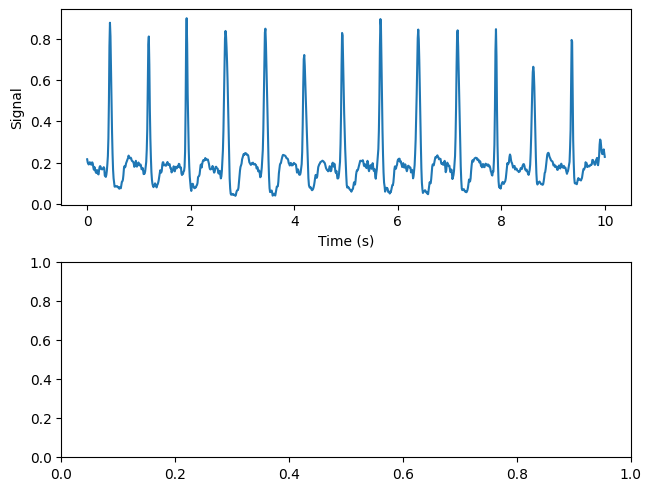

In [71]:
import matplotlib.pyplot as plt

n = np.linspace(0,10,1000)
fs = 100  # Sampling frequency (Hz)
t = np.arange(0, 1, 1/fs)  # Time vector

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, X_test[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
#ax1.psd(X_test[0], NFFT=512, Fs=fs)

plt.show()

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(n, predict_denoised_signal(model , X_test[0])[0])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Signal')
#ax1.psd(predict_denoised_signal(model , X_test[0])[0], NFFT=512, Fs=fs)

plt.show()

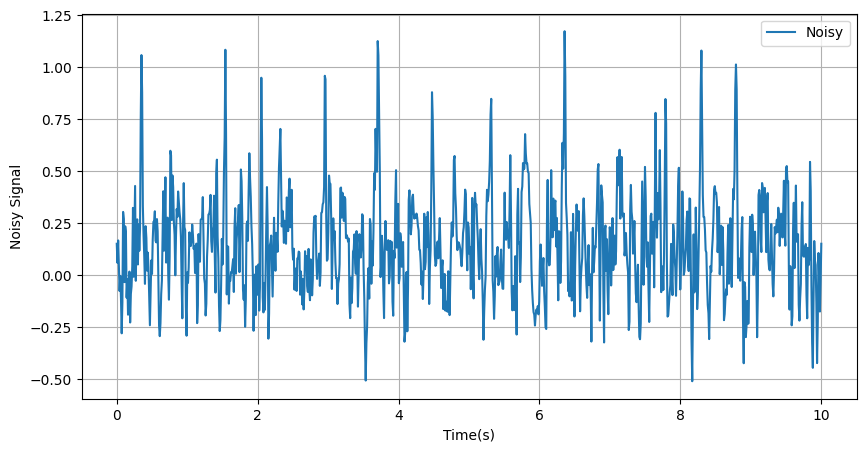

In [82]:
plt.figure(figsize=(10,5))
plt.plot(n , X_test[100] , label = 'Noisy')
plt.xlabel('Time(s)')
plt.ylabel('Noisy Signal')
plt.grid()
plt.legend()
plt.show()

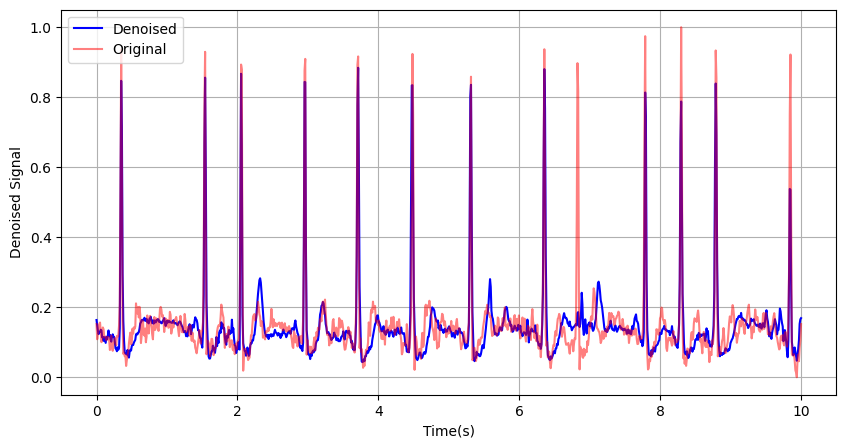

In [81]:
plt.figure(figsize=(10,5))
plt.plot(n , predict_denoised_signal(model , X_test[100])[0] , color = 'blue' , label = 'Denoised')
plt.plot(n , y_test[100] , color = 'red' , alpha = 0.5 , label = 'Original')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Denoised Signal')
plt.grid()
plt.show()

In [83]:
from scipy.signal import find_peaks, hilbert, correlate
from scipy.stats import linregress

def calculate_heart_rate(signal, fs=100, min_hr=40, max_hr=180):
    """
    Calculate heart rate from a 10s ECG signal using MFHT method.
    
    Args:
        signal: 1D ECG signal (10 seconds duration)
        fs: Sampling frequency (Hz)
        min_hr/max_hr: Physiologically plausible limits (bpm)
    
    Returns:
        hr: Estimated heart rate (bpm)
        peak_locs: R-peak locations (in samples)
    """
    # 1. Create template from the signal itself
    max_loc = np.argmax(signal)
    template = signal[max_loc-10 : max_loc+20]  # 30ms QRS template
    
    # 2. Cross-correlation with template
    corr = correlate(signal - np.mean(signal), 
                   template - np.mean(template),
                   mode='same')
    
    # 3. Hilbert envelope detection
    envelope = np.abs(hilbert(corr))
    
    # 4. Find peaks with physiologically valid constraints
    min_peak_distance = int(fs * (60/max_hr))  # Max HR = 180bpm → 0.33s
    peaks, _ = find_peaks(envelope, 
                         distance=min_peak_distance,
                         height=np.mean(envelope)*1.5)
    
    # 5. Calculate HR from median RR interval
    if len(peaks) >= 2:
        rr_intervals = np.diff(peaks) / fs  # Convert to seconds
        hr = 60 / np.median(rr_intervals)
        return np.clip(hr, min_hr, max_hr), peaks
    else:
        return np.nan, peaks  # Return NaN if no valid peaks

def plot_hr_results(clean_signals, noisy_signals, denoised_signals, fs=100):
    """
    Compare HR estimation before/after denoising for 10s signals.
    
    Args:
        clean_signals: List of reference Lead I ECG signals (each 10s)
        noisy_signals: List of raw in-ear ECG signals
        denoised_signals: List of processed in-ear ECG signals
        fs: Sampling frequency (Hz)
    """
    # Initialize arrays
    hr_ref = np.zeros(len(clean_signals))
    hr_noisy = np.zeros(len(noisy_signals))
    hr_denoised = np.zeros(len(denoised_signals))
    
    # Calculate HR for each 10s segment
    for i in range(len(clean_signals)):
        hr_ref[i], _ = calculate_heart_rate(clean_signals[i], fs)
        hr_noisy[i], _ = calculate_heart_rate(noisy_signals[i], fs)
        hr_denoised[i], _ = calculate_heart_rate(denoised_signals[i], fs)
    
    # Filter out invalid estimates
    valid_mask = (~np.isnan(hr_ref)) & (~np.isnan(hr_noisy)) & (~np.isnan(hr_denoised))
    hr_ref = hr_ref[valid_mask]
    hr_noisy = hr_noisy[valid_mask]
    hr_denoised = hr_denoised[valid_mask]
    
    # Calculate MAE
    mae_before = np.mean(np.abs(hr_ref - hr_noisy))
    mae_after = np.mean(np.abs(hr_ref - hr_denoised))
    
    # Create plot
    plt.figure(figsize=(10, 5))
    plt.scatter(hr_ref, hr_noisy, c='#1f77b4', alpha=0.6, 
                label=f'Before (MAE={mae_before:.1f} bpm)')
    plt.scatter(hr_ref, hr_denoised, c='#ff7f0e', alpha=0.6,
                label=f'After (MAE={mae_after:.1f} bpm)')
    
    # Add reference line and annotations
    max_hr = max(np.nanmax(hr_ref), np.nanmax(hr_noisy), np.nanmax(hr_denoised))
    plt.plot([40, max_hr], [40, max_hr], 'k--', alpha=0.3)
    plt.text(0.05, 0.9, f"MAE Reduction: {100*(mae_before-mae_after)/mae_before:.0f}%",
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Formatting
    plt.title("Heart Rate Estimation (10s Segments)", pad=20)
    plt.xlabel("Reference HR (Lead I ECG, bpm)")
    plt.ylabel("Estimated HR (bpm)")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.xlim(40, max_hr+5)
    plt.ylim(40, max_hr+5)
    plt.show()

In [135]:
y_pred = np.empty(shape=(len(X_test)//5 , 1000))
clean_signals = np.empty(shape=(len(X_test)//5 , 1000))
noisy_signals = np.empty(shape=(len(X_test)//5 , 1000))

In [142]:
for i in range(len(X_test)):
    noisy_signals[i] = X_test[i]
    clean_signals[i] = y_test[i]
    y_pred[i] = (predict_denoised_signal(model , X_test[i]))

IndexError: index 218 is out of bounds for axis 0 with size 218

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, hilbert, find_peaks, ricker
from sklearn.metrics import mean_absolute_error

# ---------- helpers ----------
def bandpass_ecg(x, fs, low=5.0, high=20.0, order=4):
    sos = butter(order, [low/(fs/2), high/(fs/2)], btype='bandpass', output='sos')
    return sosfiltfilt(sos, x)

def qrs_template(fs, duration=0.12):
    # simple biphasic QRS-like template (Ricker wavelet)
    n = max(7, int(duration*fs))
    n += (n+1) % 2  # force odd
    a = max(2, int(0.22*n))
    tpl = ricker(n, a)
    tpl /= np.linalg.norm(tpl) + 1e-12
    return tpl

# ---------- MFHT HR estimation ----------
def estimate_hr_mfht(signal, fs=100, min_bpm=36, max_bpm=180, tpl=None):
    """
    Matched Filter + Hilbert envelope + peak picking.
    Returns (hr_bpm, r_peaks_idx)
    """
    x = signal.astype(float)
    x -= np.median(x)
    x_f = bandpass_ecg(x, fs)

    # matched filter
    tpl = qrs_template(fs) if tpl is None else tpl / (np.linalg.norm(tpl)+1e-12)
    y = np.convolve(x_f, tpl[::-1], mode='same')

    # Hilbert envelope + smooth
    env = np.abs(hilbert(y))
    win = max(3, int(0.08*fs))   # ~80 ms
    ker = np.ones(win)/win
    env_s = np.convolve(env, ker, mode='same')

    # peak picking with physiological refractory
    min_dist = int(round(fs*60/max_bpm))         # ~333 ms for 180 bpm
    prom = 0.5*np.std(env_s) + 1e-12
    hgt  = np.median(env_s) + 0.3*np.std(env_s)
    cand, _ = find_peaks(env_s, distance=min_dist, prominence=prom, height=hgt)

    if len(cand) < 2:
        return np.nan, cand

    # refine to R-peaks on filtered signal near envelope peaks
    half = int(0.05*fs)  # ±50 ms
    rpeaks = []
    for p in cand:
        a = max(0, p-half); b = min(len(x_f), p+half+1)
        rpeaks.append(a + np.argmax(x_f[a:b]))
    rpeaks = np.array(sorted(set(rpeaks)))

    if len(rpeaks) < 2:
        return np.nan, rpeaks

    rr = np.diff(rpeaks)/fs  # seconds
    rr = rr[(rr > 60/max_bpm) & (rr < 60/min_bpm)]
    if len(rr) == 0:
        return np.nan, rpeaks

    hr = 60.0/np.median(rr)  # robust HR
    return float(hr), rpeaks

# ---------- scatter plot ----------
def plot_hr_scatter_mfht(clean_signals, noisy_signals, denoised_signals, fs=100):
    """Scatter vs. clean (reference) using MFHT, smoothed look."""
    hr_clean   = np.array([estimate_hr_mfht(s, fs)[0] for s in clean_signals])
    hr_noisy   = np.array([estimate_hr_mfht(s, fs)[0] for s in noisy_signals])
    hr_denoise = np.array([estimate_hr_mfht(s, fs)[0] for s in denoised_signals])

    # drop NaNs
    m = ~np.isnan(hr_clean) & ~np.isnan(hr_noisy) & ~np.isnan(hr_denoise)
    hr_clean, hr_noisy, hr_denoise = hr_clean[m], hr_noisy[m], hr_denoise[m]

    mae_noisy   = mean_absolute_error(hr_clean, hr_noisy)
    mae_denoise = mean_absolute_error(hr_clean, hr_denoise)

    # continuous look: many points + low alpha; or switch to hexbin by setting use_hex=True
    plt.figure(figsize=(6,7))
    plt.scatter(hr_clean, hr_noisy,   s=14, alpha=0.25, label=f"In-ear (noisy), MAE: {mae_noisy:.2f} bpm")
    plt.scatter(hr_clean, hr_denoise, s=14, alpha=0.25, label=f"Denoised, MAE: {mae_denoise:.2f} bpm")

    lo = np.nanmin([hr_clean, hr_noisy, hr_denoise]) - 2
    hi = np.nanmax([hr_clean, hr_noisy, hr_denoise]) + 2
    plt.plot([lo, hi], [lo, hi], 'k--', lw=2, label='y = x line')

    plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.xlabel("Reference HR from Clean ECG (bpm)")
    plt.ylabel("Estimated HR (bpm)")
    plt.title("HR estimation (MFHT)")
    plt.legend(frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


C:\Users\darkoob\AppData\Local\Temp\ipykernel_9160\159747675.py:16: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  tpl = ricker(n, a)


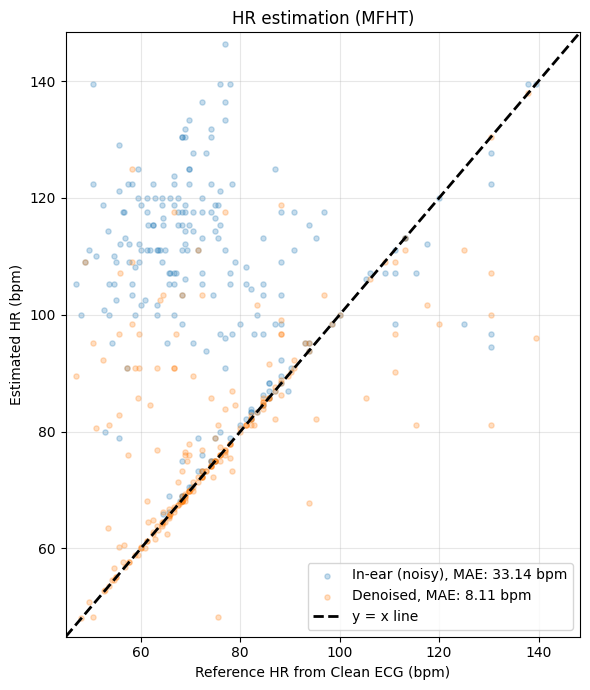

In [145]:
plot_hr_scatter_mfht(clean_signals, noisy_signals, y_pred, fs=100)
